### MAT3110/MAT4110, Autumn 2024, Compulsory assignment 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

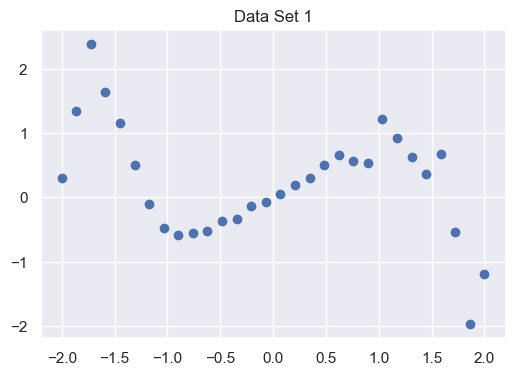

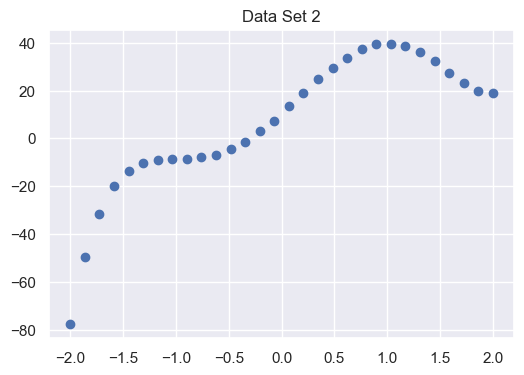

In [2]:
sns.set_theme()
#Generate data sets pulled from exercise
eps = 1 # noise constant, can be varied

#Set 1
n = 30
start, stop = -2, 2
eps = 1
np.random.seed(1)
x = np.linspace(start, stop, n)
r = np.random.rand(n) * eps

# First dataset 
y1 = x * (np.cos(r + 0.5 * x**3) + np.sin(0.5 * x**3))

# Second dataset
y2 = 4 * x**5 - 5 * x**4 - 20 * x**3 + 10 * x**2 + 40 * x + 10 + r


# Plot data sets
plt.figure(figsize=(6,4))
plt.plot(x, y1, 'o')
plt.title('Data Set 1')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x, y2, 'o')
plt.title('Data Set 2')
plt.show()

We want to do least squares polynomial fitting with two methods with the use of the Vandermonde matrix. 
https://en.wikipedia.org/wiki/Vandermonde_matrix

We want to find x which minimizes the 2-norm squared of Ax-b. One through QR factorization of A and the other through normal equations.


1st method:

We want to implement making a vandermonde matrix, back- and forwardsubstitution.

In [3]:
# Vander matrix

def make_vander(x, n):
    '''
    x: vector input, 1d array
    n: number of column in the the output, power of x minus 1. (m = 3 -> max power = x**2)
    
    Set increasing true such that power increases to the right, matches task
    '''
    return np.vander(x, n, increasing=True)

#x = np.array([2, 4, 10])
#print(make_vander(x, 3))

#Use back sub from weekly exercises
def back_substitution(A, b):
    '''
    A: Square upper triangular matrix (n x n)
    b: 1d vector (n), 

    Solves the system by starting from the last row of the matrix (the simplest equation) 
    and working upwards to solve for each unknown
    '''
    n = np.shape(A)[0]
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        temp_sum = 0
        for j in range(i + 1, n):
            temp_sum += A[i, j] * x[j]
        x[i] = (b[i] - temp_sum) / A[i, i]
    return x


def QR_solve(A, b):
    ''' 
    A: Matrix (n x m) 
    b: vector (n), right side of the equation system

    Decomposition with QR from numpy, then use backsub to find solutions x
    The solution is found by solving the system Rx = Q_T b using back substitution. 
    Which is like Ax = b where A is upper triangular matrix.
    '''
    Q, R = np.linalg.qr(A) # returns orthogonal matrix Q and upper triangular matrix R
    b_ = np.dot(Q.T, b)
    x = back_substitution(R, b_)
    return x


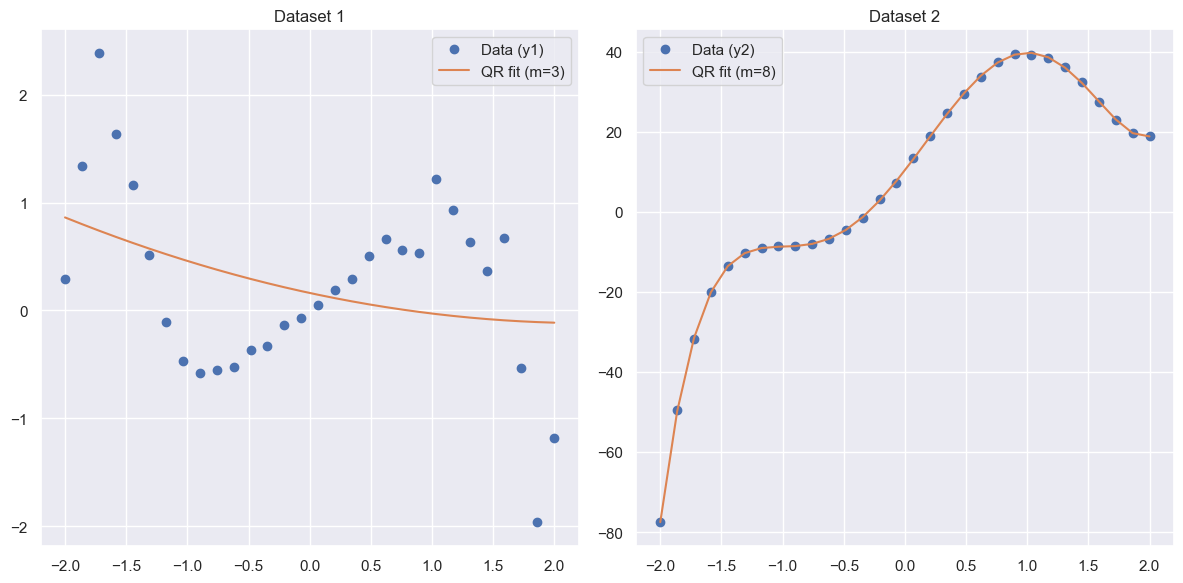

In [5]:
# Solve with QR
# m - columns
m1 = 3 # 2nd degree poly
m2 = 8 # 7th degree poly

# Vandermonde with dataset
A_1 = make_vander(x, m1)
A_2 = make_vander(x, m2) 

# Fit the first dataset (y1)
x1_QR = QR_solve(A_1, y1)
y1_pred_QR = np.dot(A_1, x1_QR)

# Fit the second dataset (y2)
x2_QR = QR_solve(A_2, y2)
y2_pred_QR = np.dot(A_2, x2_QR)

# Plot results for the first dataset
plt.figure(figsize=(12, 6))

# Plot for y1
plt.subplot(1, 2, 1)
plt.plot(x, y1, 'o', label='Data (y1)')
plt.plot(x, y1_pred_QR, '-', label='QR fit (m=3)')
plt.title('Dataset 1')
plt.legend()

# Plot for y2
plt.subplot(1, 2, 2)
plt.plot(x, y2, 'o', label='Data (y2)')
plt.plot(x, y2_pred_QR, '-', label='QR fit (m=8)')
plt.title('Dataset 2')
plt.legend()

plt.tight_layout()
plt.show()